/home/carladm/Documents/tDLGM/experiments/data_parsing/data_gen.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = df.max()[0]


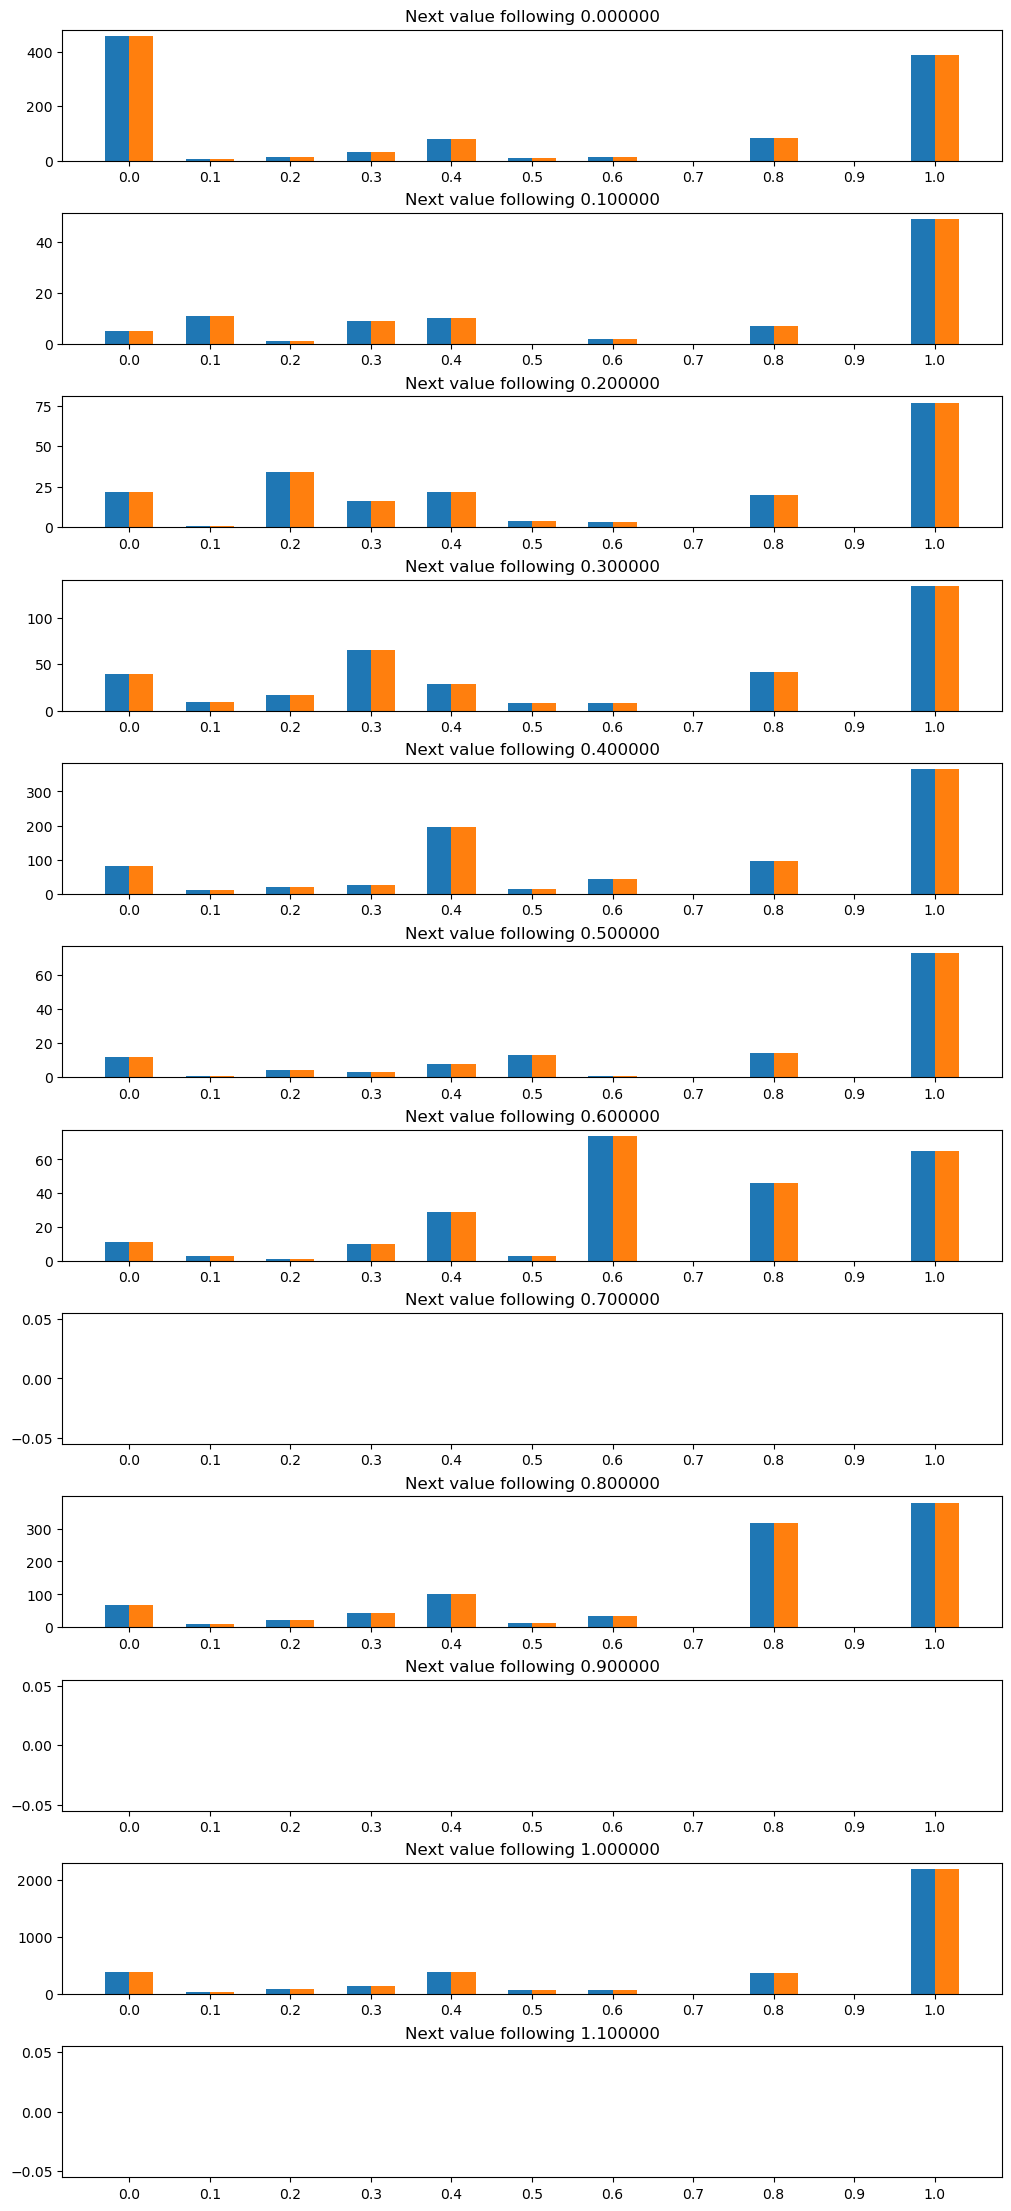

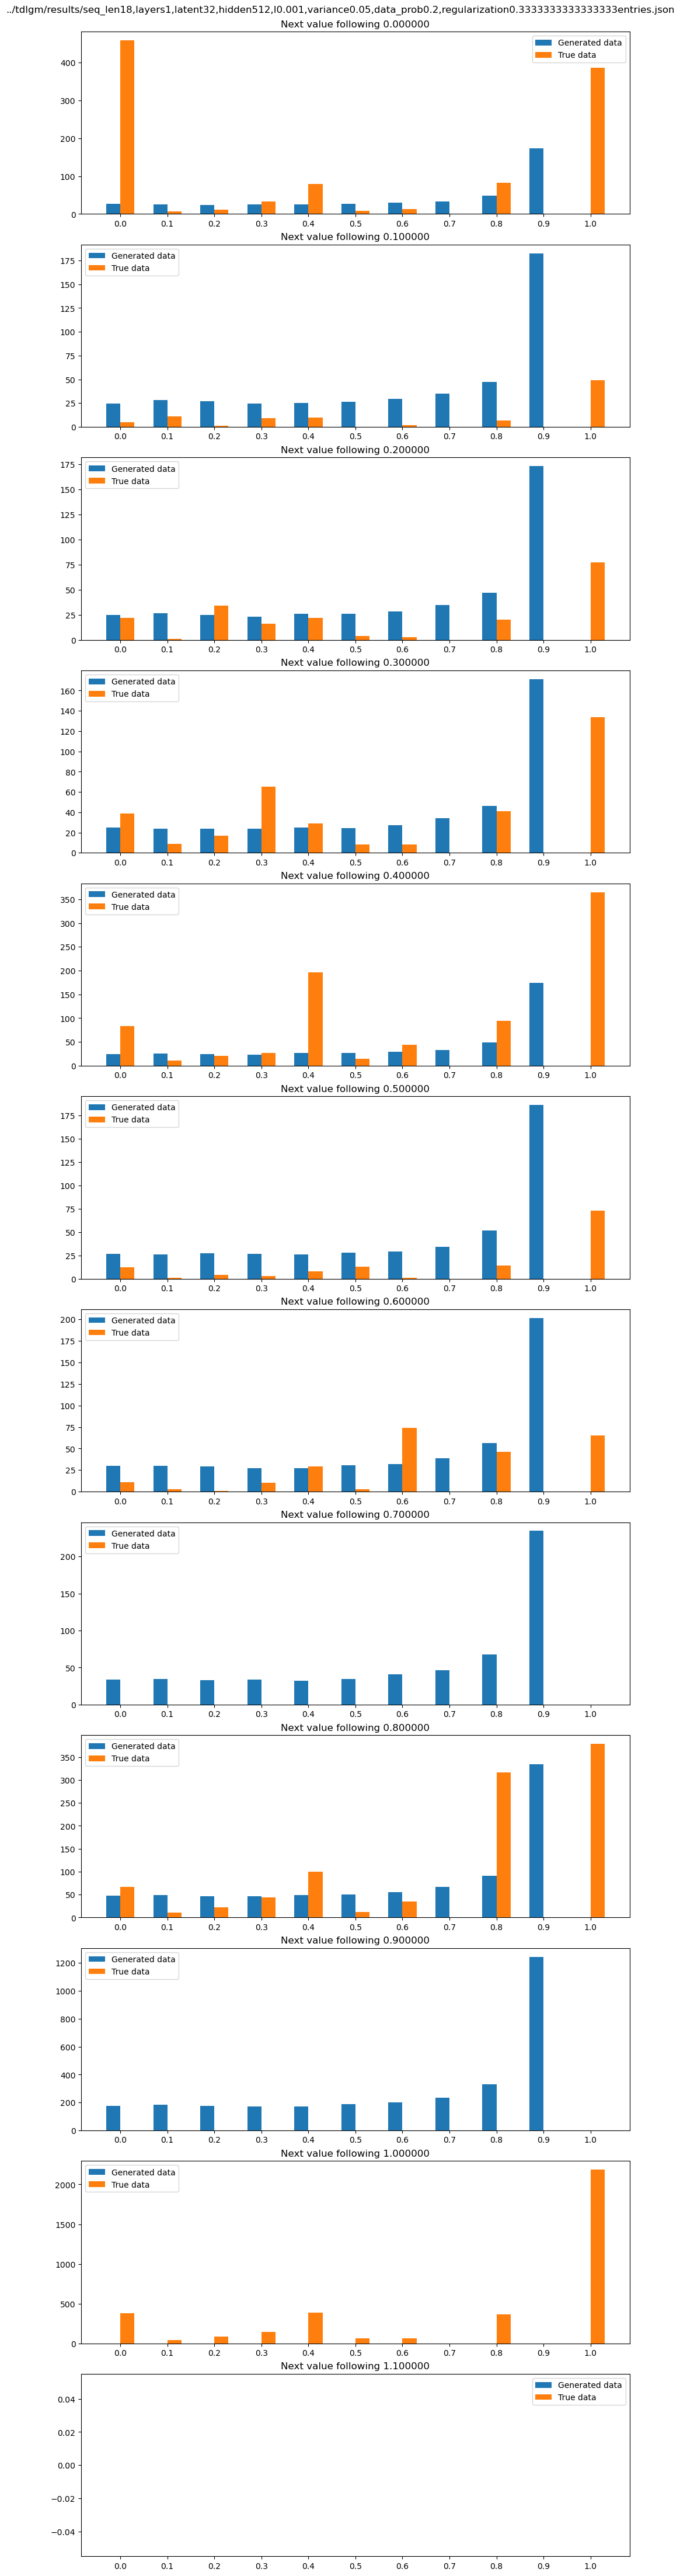

BEST_SCORE:  54.696985000183645


In [2]:
import data_handling as dh
from data_gen import Datagen
import matplotlib.pyplot as plt
import numpy as np

gen = Datagen(None)
_, y_true, _ = gen.get_true_data(1)


types = {"tdlgm": "../tdlgm/results"}#, "dlgm": "../dlgm/results", "rnn": "../rnn/results"}

#types = {"tdlgm": "../tdlgm/results", "rnn": "../rnn/results"}




def _future_eval_bin(values, low, high, stepsize, future_steps=1):
    bins = dh.get_bin(values, low, high, stepsize)
    order = dh.get_bin_order(values,low,high,stepsize)
    k = bins.keys()
    to_return = {}
    for i in k:
        to_return[i] = {}
        for j in k:
            to_return[i][j] = 0

    for i in range(len(order) -  future_steps):
        to_return[order[i]][order[i+future_steps]] += 1
    
    return to_return
    
def future_eval_bin(f, low, high, stepsize):

    r = _future_eval_bin(f["future"][-1]["result"][0]["generated"], low, high, stepsize)
    for i in f["future"][-1]["result"][1:]:
        curr = _future_eval_bin(i["generated"], low, high, stepsize)

        for k in curr:
            for j in curr:
                r[k][j] += curr[k][j]
    return r
def scale(r, true):
    count_t = 0
    count_r = 0
    for k in true:
        for j in true:
            count_t += true[k][j]
            count_r += r[k][j]
    scaling = count_t/count_r
    for k in r:
        for j in r:
            r[k][j] = r[k][j]*scaling
    return r

            
def model_future_eval_bin(model, low, high, stepsize, true):
    options = [model + "/" + i for i in dh.get_all_files(model)]

    for o in options:
        f = dh.get_file(o)[0]
        r = future_eval_bin(f,low,high,stepsize)

        fig, ax = plt.subplots(len(r.keys()),figsize=(10,22),  layout="constrained")
        r = scale(r, true)
        for a, k in zip(ax, r):
            width = 0.3
            index = np.arange(len(r[k]) - 1)
            a.bar(index , list(r[k].values())[:-1], width, label="Generated data")
            a.bar(index + width, list(true[k].values())[:-1], width, label="True data")
            a.set_xticks(index + width / 2)

            labels = []
            for i in range(len(r[k].keys()) - 1):
                labels.append("[%f,%f)" % (r[k].keys()[i], r[k].keys()[i+1]))
            a.set_xticklabels(labels)

            a.set_title("Next value following %f" % k)
            a.set_xaxis("Value range")
            a.set_yaxis("Amount of instances (scaled)")
            a.legend()
        fig.suptitle(o)
        plt.show()
        plt.close()
        

def best_future_eval_bin(model, low, high, stepsize, true):
    options = [model + "/" + i for i in dh.get_all_files(model)]
    score = 0
    best = None
    for o in options:
        f = dh.get_file(o)[0]
        r = future_eval_bin(f,low,high,stepsize)
                
        r = scale(r, true)

        curr = 0
        for k in r:
            for j in r:
                
                s = min(r[k][j], true[k][j])
                if s != 0:
                    curr += s/true[k][j]
                
        if curr > score:
            score = curr
            best = r
                
    fig, ax = plt.subplots(len(r.keys()),figsize=(10,44),  layout="constrained")
    for a, k in zip(ax, best):
        width = 0.3
        index = np.arange(len(r[k]) - 1)
        a.bar(index , list(best[k].values())[:-1], width, label="Generated data")
        a.bar(index + width, list(true[k].values())[:-1], width, label="True data")
        a.set_xticks(index + width / 2)
        a.set_xticklabels(list(best[k].keys())[:-1])

        a.set_title("Next value following %f" % k)
        a.legend()
    fig.suptitle(o)
    plt.show()
    plt.close()
    print("BEST_SCORE: ", score)
        




#f = dh.get_file("../tdlgm/results/seq_len20,layers1,latent4,hidden512,l1e-07,variance0.05,data_prob0.4,regularization0entries.json")

r = _future_eval_bin(y_true, 0,1,0.1)
fig, ax = plt.subplots(len(r.keys()),figsize=(10,22), layout="constrained")
for a,k in zip(ax, r):
    width = 0.3
    index = np.arange(len(r[k]) - 1)
    a.bar(index , list(r[k].values())[:-1], width, tick_label=list(r[k].keys())[:-1])
    a.bar(index + width, list(r[k].values())[:-1], width ,tick_label=list(r[k].keys())[:-1])
    a.set_xticks(index + width / 2)
    a.set_xticklabels(list(r[k].keys())[:-1])

    a.set_title("Next value following %f" % k)
#best_future_eval_bin(types["dlgm"], 0,1,0.1, r)
best_future_eval_bin(types["tdlgm"], 0,1,0.1, r)
#best_future_eval_bin(types["rnn"], 0,1,0.1, r)


In [ ]:

future_eval_bin(f[0], 0,1,0.1)
model_future_eval_bin(types["tdlgm"], 0,1,0.1, r)

In [ ]:
dh.plot_all_future(types["tdlgm"], "tdlgm_future/")
dh.plot_all_future(types["rnn"], "rnn_future/")
dh.plot_all_future(types["dlgm"], "dlgm_future/")


In [ ]:
for t in types:
    print("*"*20, "LOWEST FUTURE EVAL", "*"*20, "\n",t)
    res = dh.lowest_future_eval(types[t])
    print("\tName: %s \n\tScore: %f" % ( res["name"], res["value"]))
    dh.plot_future(res["name"], title=t)




In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import data_handling as dh
from data_gen import Datagen
from termcolor import colored
from scipy.stats import ttest_ind

from IPython.display import HTML as html_print


In [ ]:

def allowed(f):
    return f[0]["diff_squared_mean"]/f[-1]["diff_squared_mean"]

def get_file(filename="entries"):
    l = None
    with open(filename, "r") as f:
        l = json.loads(f.read())
    return l

def color_print(s, color='black'):
    display(html_print(("<text style=color:{}>{}</text>".format(color, s))))


In [ ]:
tdlgm = dh.get_all_files(types["tdlgm"])
rnn = dh.get_all_files(types["rnn"])

In [ ]:
results = []
for i in rnn:
    to_add = {}
    to_add["name"] = i
    
    f = dh.get_file(types["rnn"] + "/" + i)[0]

    p = allowed(f["future_eval"])

    to_add["frac"] = p

    print("*" * 20, "\n", i, "\n")
    color = "red"
    if p < 0.9:
        color = "green"
    color_print([(k["steps"], round(k["diff_squared_mean"], 4)) for k in f["future_eval"]], color)
    print( "*" * 20)
    results.append(to_add)

In [ ]:
for i in results:
    if i["frac"] < 0.7:
        f = dh.get_file(types["rnn"] + "/" +i["name"])[0]
        ep.get_bin( f["y_hat"][0])

In [ ]:

def get_bin(y, low, high, step_size):
    count = {}
    values = np.around(np.arange(low, high + step_size*2, step_size), decimals=2)
    for i in values:
        count[i] = 0
    for i in y:
        prev = values[0]
        for j in values:
            if i < j:
                count[prev] += 1
                break
            prev = j
            
    
    return count

def bin_plot(y, low, high, step_size, extra_str=""):
    count = get_bin(y, low, high, step_size)
    names = list(count.keys())
    values = list(count.values())
    fig, ax = plt.subplots(figsize=(12,12))
    ax.bar(range(len(count) -1), values[:-1], tick_label=names[:-1])

def bin_diff(q_bar, p_bar):
    q_val = np.array([q_bar[k] for k in q_bar])
    p_val = np.array([p_bar[k] for k in p_bar])
    q = q_val/np.sum(q_val)
    p = p_val/np.sum(p_val)
    score = 0
    for i in range(len(q)):
        score += min(p[i],q[i])
    return score
    
bin_true = get_bin(y_true, 0,1,0.1)

print(diff(bin_true, bin_true))

bin_plot(y_true, 0,1,0.1)

In [ ]:
for i in results:
    if i["frac"] < 0.7:
        f = dh.get_file(types["rnn"] + "/" +i["name"])[0]
        print(diff(get_bin(f["y_hat"][0], 0,1,0.1),bin_true))
        bin_plot( f["y_hat"][0],0,1, 0.1)